In [3]:
# import numericals
import numpy as np
from numpy import array
from numpy import hstack
from numpy.random import seed
import pandas as pd
from datetime import datetime
import random
import matplotlib.pyplot as plt

# import machine learning
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV,train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import warnings
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
# define some functions
def create_col_labels(lookback):
  index=[i for i in range(lookback+1)]
  index.remove(0)
  cols=["t-"+str(i) for i in index]
  cols=cols[::-1]
  cols.append("t+1")
  return cols
#------------------------------------------------------------------------------------------------
def invert_rate(rate,scaler):
  rate = np.array(rate).reshape(-1,1)
  rate = scaler.inverse_transform(rate)
  return rate
#------------------------------------------------------------------------------------------------
def error_metrics (Y,Y_hat):
    error =abs((Y-Y_hat)/Y)
    return error*100
#------------------------------------------------------------------------------------------------
def create_col_labels(lookback):
  index=[i for i in range(lookback+1)]
  index.remove(0)
  cols=["t-"+str(i) for i in index]
  cols=cols[::-1]
  cols.append("t+1")
  return cols
#------------------------------------------------------------------------------------------------
def time_series_to_sup(data,lookback):
  list_concat=[data.shift(i) for i in range(lookback+1)]
  list_concat=list_concat[::-1]
  df = pd.concat(list_concat, axis=1)
  cols=create_col_labels(lookback)
  df.columns = cols
  df2=df.drop(index=[i for i in range(lookback)])
  X=df2[cols[:-1]]
  y=df2[cols[-1]]
  return np.array(X),np.array(y)[:,np.newaxis]
#------------------------------------------------------------------------------------------------
def read_production_data(filename,scale,scale_type):
  df=pd.read_excel(filename)
  y=df.Qo
  if scale == 1 and scale_type == 'MinMax':
      y = np.array(y).reshape(-1,1)
      scalerY = MinMaxScaler().fit(y)
      y=scalerY.transform(y)
  if scale == 1 and scale_type =='Standard':
      y = np.array(y).reshape(-1,1)
      scalerY = StandardScaler().fit(y)
      y=scalerY.transform(y)
  return y,scalerY
#------------------------------------------------------------------------------------------------

def plot_curves(test,predicted,scalerY,model_name,algo):
    from sklearn.utils import resample
    # convert to array
    test=np.array(test)
    predicted=np.array(predicted)
    # compute r2 and mape
    r2=metrics.r2_score(invert_rate(test,scalerY),invert_rate(predicted,scalerY))
    error=error_metrics(invert_rate(test,scalerY),invert_rate(predicted,scalerY))
    # perform bootstrap
    bs=[]
    for i in range(100):
      bs_data=resample(error)
      bs.append(np.mean(bs_data))
    # bs: mean and std_mean
    bs_mean=np.mean(bs)
    std_mean=np.std(bs)
    # scale data for plotting (0,1) range
    predicted,test=scale_plot(predicted,test)
    # create plots
    plt.figure(figsize=(5,3))
    plt.plot(predicted,color='black',lw=3,label='Predicted')
    plt.plot(test,'o',color='yellow',mec=(0,0,0),label='Truth')
    plt.ylabel('$\it{Q_o}$')
    plt.xlabel('Time [months]')
    plt.legend()
    plt.title(f"{algo}: MAPE={round(bs_mean,1)}%")
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{model_name}.svg",dpi=500)
    return bs_mean,r2
#------------------------------------------------------------------------------------------------
def scale_plot(predictions,T):
  scaler_p = MinMaxScaler().fit(predictions[:,np.newaxis])
  scaler_t = MinMaxScaler().fit(T)
  predictions=scaler_p.transform(predictions[:,np.newaxis])
  T=scaler_t.transform(T)
  return predictions,T

In [10]:
# read dataset
y_raw,scalerY=read_production_data("q.xlsx",1,'Standard')

In [11]:
# invoke machine learning model
model=KernelRidge(kernel="linear",gamma=1e-2,alpha=1e-2)
n_steps_out=1 # 1-step ahead predictor for 2dsaw
# y_raw contains oil flowrate data (N_samples,1)
data = pd.DataFrame(y_raw)
# convert timeseries dataset to supervised format
# 2nd argument of "time_series_to_sup" specifies the lookback or
# context window size
# e.g. for lookback=3, we have qo[t]=f(qo[t-1],qo[t-2],qo[t-3])
lookback=3
X,y=time_series_to_sup(data,lookback);qo=y
# define some properties of the walk-forward analysis
size_test=12 # the forecast horizon: 12 months
size_train=36 # the training window size, in case sliding windows are used
size_0=40 # initial dataset size for the walk-forward analysis
forget="N" # sliding windows ("Y") or expanding windows ("N", so no forgetting)
i=0
splits=np.arange(size_0,len(qo),size_test) # define end-of-set for walk-forward analysis

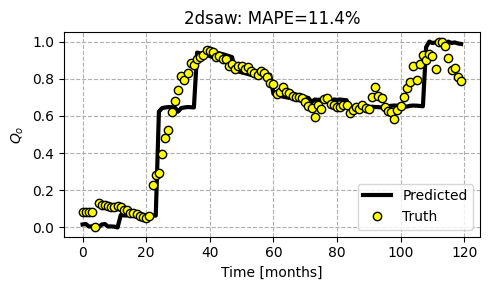

In [12]:
# initialize some lists
predicted,test=[],[]
# launch walk-forward analysis
while i<len(splits):
    # read end of sequence for Phase 1 of 2dsaw
    i_end=splits[i]-int(size_test/2)
    # read end of sequence for Phase 2 of 2dsaw
    i_end2=splits[i]
    # assemble dataset for Phase 1 (1 dimensional flowrate sequence)
    dataset=qo[0:i_end]
    # assemble dataset for Phase 2 (1 dimensional flowrate sequence)
    dataset2=qo[0:i_end2]
    # assign dataset for Phase 1
    dataset_new=dataset
    for k in range(2):
      # set seeds
      np.random.seed(42)
      # convert timeseries dataset to supervised format
      if k==0:
        X,y=time_series_to_sup(pd.DataFrame(dataset_new),lookback)
      # train-test split
      X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=n_steps_out,shuffle=False)
      # train the 1-step ahead predictor
      if forget=="N": # for expanding windows
        model.fit(X_train, y_train)
      else: # for sliding windows
        model.fit(X_train[-size_train:,], y_train[-size_train:,])
      # recursive prediction using the 1-step ahead model
      XX=X_test
      for n_steps in range(size_test-int(size_test/2)):
        # predict 1-step ahead
        y_hat_one=model.predict(XX)
        # save prediction to list
        predicted.append(y_hat_one[0])
        # augment XX by adding prediction and dropping oldest sample
        # this is a recursive prediction using predicted samples
        # as prompts
        XX=np.concatenate([XX[:,1:],y_hat_one],axis=1)
      # save ground truth
      if k==0: # for Phase 1 use "dataset"
        test.extend(dataset[-size_test+int(size_test/2):,0])
      else: # for Phase 2 use "dataset2"
        test.extend(dataset2[-size_test+int(size_test/2):,0])
      # augment dataset for Phase 2
      # it contains the original "dataset" used in Phase 1 plus
      # all past predictions up until now
      if k==1:
         X1,y1=time_series_to_sup(pd.DataFrame(dataset),lookback)
         X2,y2=time_series_to_sup(pd.DataFrame(predicted),lookback)
         X=np.concatenate([X1,X2],axis=0)
         y=np.concatenate([y1,y2],axis=0)
    # go to the next set of the walk-forward analysis
    i=i+1
# convert ground truth to arrays
tt=np.array(test).flatten()[:,np.newaxis]
pp=np.array(predicted).flatten()[:,np.newaxis]
# plot "truth" vs "predicted"
mape,r2=plot_curves(tt,pp.squeeze(),scalerY,"2dsaw","2dsaw")